# Plot ROC curves 

# 1. Set up

In [ ]:
 from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 18323763099877740391
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6603002312422558889
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [ ]:
!pip install tensorflow-addons --quiet

     |████████████████████████████████| 1.1 MB 8.7 MB/s 


In [ ]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications.vgg19 import preprocess_input
import tensorflow_addons as tfa
import os
import tempfile


from keras.utils.vis_utils import plot_model

import sklearn
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import label_binarize
from itertools import cycle

In [ ]:
# Define paths:
pathtoCSV = '/content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/CSV_Files/'
pathtoImages = '/content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/Images/'
pathtoSave = '/content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/Saved_models/VGG19/'
pathtoResults = '/content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/Models_performance/VGG19/Strategic_sophistication/ROC_curves/'

#2. Load validation and test data

In [ ]:
labels_csv = pd.read_csv(pathtoCSV + 'train_val_levels.csv',dtype=str)

In [ ]:
val_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
)
labels_csv['Levels'] = labels_csv['Levels'].astype(str)
labels_csv['code'] = labels_csv['code'].astype(str)

val_generator = val_datagen.flow_from_dataframe(
    labels_csv,
    directory = pathtoImages + 'Validation',
    x_col = 'code',
    y_col = 'Levels',
    target_size = (224,224),
    color_mode='rgb',
    shuffle=False,
    seed= 1,
    class_mode = 'categorical',
    batch_size = 16
)

Found 480 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1700 invalid image filename(s) in x_col="code". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
# load test data:
labels_xl = pd.read_csv(pathtoCSV + 'test_L1L2.csv',dtype=str)

# Paths to test images:
test_percentage = 'test_percentages/'
test_timing = 'test_timings/'

In [ ]:
def load_test_images(test_full, test_80, test_50, test_30, test_15, test_15s, test_10s, test_5s, test_2s):
  test_datagen = ImageDataGenerator(
      preprocessing_function = preprocess_input,
  )
  labels_xl['Levels'] = labels_xl['Levels'].astype(str)
  labels_xl['code'] = labels_xl['code'].astype(str)

  test_generator_full_images = test_datagen.flow_from_dataframe(
      labels_xl,
      directory = test_full,
      x_col = 'code',
      y_col = 'Levels',
      target_size = (224,224),
      color_mode='rgb',
      shuffle=False,
      seed= 1,
      class_mode = 'categorical',
      batch_size = 16
)
  test_generator_80_percent = test_datagen.flow_from_dataframe(
      labels_xl,
      directory = test_80,
      x_col = 'code',
      y_col = 'Levels',
      target_size = (224,224),
      color_mode='rgb',
      shuffle=False,
      seed= 1,
      class_mode = 'categorical',
      batch_size = 16
  )
  test_generator_50_percent = test_datagen.flow_from_dataframe(
      labels_xl,
      directory = test_50,
      x_col = 'code',
      y_col = 'Levels',
      target_size = (224,224),
      color_mode='rgb',
      shuffle=False,
      seed= 1,
      class_mode = 'categorical',
      batch_size = 16
  )
  test_generator_30_percent = test_datagen.flow_from_dataframe(
      labels_xl,
      directory = test_30,
      x_col = 'code',
      y_col = 'Levels',
      target_size = (224,224),
      color_mode='rgb',
      shuffle=False,
      seed= 1,
      class_mode = 'categorical',
      batch_size = 16
  )
  test_generator_15_percent = test_datagen.flow_from_dataframe(
      labels_xl,
      directory = test_15,
      x_col = 'code',
      y_col = 'Levels',
      target_size = (224,224),
      color_mode='rgb',
      shuffle=False,
      seed= 1,
      class_mode = 'categorical',
      batch_size = 16
  )
  test_generator_15_secs = test_datagen.flow_from_dataframe(
      labels_xl,
      directory = test_15s,
      x_col = 'code',
      y_col = 'Levels',
      target_size = (224,224),
      color_mode='rgb',
      shuffle=False,
      seed= 1,
      class_mode = 'categorical',
      batch_size = 16
  )
  test_generator_10_secs = test_datagen.flow_from_dataframe(
      labels_xl,
      directory = test_10s,
      x_col = 'code',
      y_col = 'Levels',
      target_size = (224,224),
      color_mode='rgb',
      shuffle=False,
      seed= 1,
      class_mode = 'categorical',
      batch_size = 16
  )
  test_generator_5_secs = test_datagen.flow_from_dataframe(
      labels_xl,
      directory = test_5s,
      x_col = 'code',
      y_col = 'Levels',
      target_size = (224,224),
      color_mode='rgb',
      shuffle=False,
      seed= 1,
      class_mode = 'categorical',
      batch_size = 16
  )
  test_generator_2_secs = test_datagen.flow_from_dataframe(
      labels_xl,
      directory = test_2s,
      x_col = 'code',
      y_col = 'Levels',
      target_size = (224,224),
      color_mode='rgb',
      shuffle=False,
      seed= 1,
      class_mode = 'categorical',
      batch_size = 16
  )

  return test_generator_full_images, test_generator_80_percent, test_generator_50_percent, test_generator_30_percent, test_generator_15_percent, test_generator_15_secs, test_generator_10_secs, test_generator_5_secs, test_generator_2_secs

In [ ]:
# Load all images
test_full = pathtoImages + 'Test/'
test_80 = pathtoImages + test_percentage + 'Test_80/'
test_50 = pathtoImages + test_percentage + 'Test_50/'
test_30 = pathtoImages + test_percentage + 'Test_30/'
test_15 = pathtoImages + test_percentage + 'Test_15/'
test_15s = pathtoImages + test_timing + 'Test_15s/'
test_10s = pathtoImages + test_timing + 'Test_10s/'
test_5s = pathtoImages + test_timing + 'Test_5s/'
test_2s = pathtoImages + test_timing + 'Test_2s/'
test_generator_full_images, test_generator_80_percent, test_generator_50_percent,  test_generator_30_percent, test_generator_15_percent, test_generator_15_secs, test_generator_10_secs, test_generator_5_secs, test_generator_2_secs = load_test_images(test_full, test_80, test_50, test_30, test_15, test_15s, test_10s, test_5s, test_2s)

Found 250 validated image filenames belonging to 3 classes.
Found 250 validated image filenames belonging to 3 classes.
Found 250 validated image filenames belonging to 3 classes.
Found 250 validated image filenames belonging to 3 classes.
Found 250 validated image filenames belonging to 3 classes.
Found 250 validated image filenames belonging to 3 classes.
Found 250 validated image filenames belonging to 3 classes.
Found 250 validated image filenames belonging to 3 classes.
Found 250 validated image filenames belonging to 3 classes.


#3. Load trained best model and define custom function for mean average precision at k 

In [ ]:
def recall(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + K.epsilon())
    return recall

In [ ]:
model = tf.keras.models.load_model(pathtoSave + 'VGG_19_Strategic_sophistication_best_model', custom_objects={'recall':recall})

#4. Validation ROC curve 

In [ ]:
STEP_SIZE_TEST=val_generator.n//val_generator.batch_size
val_generator.reset()
preds = model.predict(val_generator,verbose=1)

30/30 [==============================] - 254s 8s/step


In [ ]:
predict_label1 = np.argmax(preds, axis=-1)
labels = [0,1,2]
# Binarize ytest with shape (n_samples, n_classes)
y_true = val_generator.classes
y_test_bin = label_binarize(y_true, classes=labels)
# Binarize ypreds with shape (n_samples, n_classes)
y_preds_bin = label_binarize(predict_label1, classes=labels)

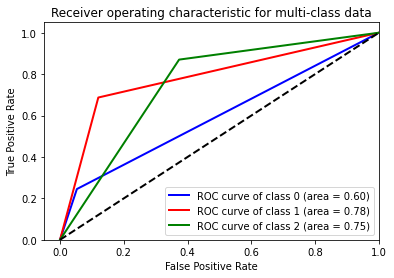

In [ ]:
# Plot ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3
lw = 2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_preds_bin[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve - Validation set')
plt.legend(loc="lower right")
plt.savefig(pathtoResults + 'roc_ES_val.png')

In [ ]:
del(preds, y_true, y_test_bin, y_preds_bin, fpr, tpr)

#5. Plot ROC of test images 

16/16 [==============================] - 114s 8s/step


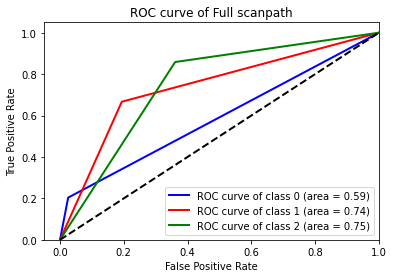

In [ ]:
# Full images
STEP_SIZE_TEST=test_generator_full_images.n//test_generator_full_images.batch_size
test_generator_full_images.reset()
preds = model.predict(test_generator_full_images,verbose=1)
predict_label1 = np.argmax(preds, axis=-1)
labels = [0,1,2]
y_true = test_generator_full_images.classes
y_test_bin = label_binarize(y_true, classes=labels)
y_preds_bin = label_binarize(predict_label1, classes=labels)

# Plot ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3
lw = 2
for i in range(n_classes):
    
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_preds_bin[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Full scanpath')
plt.legend(loc="lower right")
plt.savefig(pathtoResults + 'roc_ES_full.png')


del(preds, y_true, y_test_bin, y_preds_bin, fpr, tpr)

16/16 [==============================] - 104s 7s/step


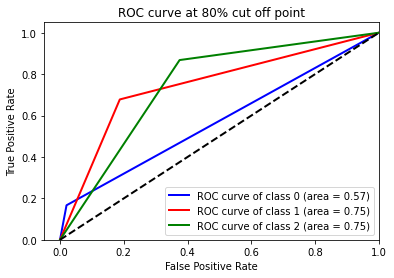

In [ ]:
# 80 percent
STEP_SIZE_TEST=test_generator_80_percent.n//test_generator_80_percent.batch_size
test_generator_80_percent.reset()
preds = model.predict(test_generator_80_percent,verbose=1)
predict_label1 = np.argmax(preds, axis=-1)
labels = [0,1,2]
y_true = test_generator_80_percent.classes
y_test_bin = label_binarize(y_true, classes=labels)
y_preds_bin = label_binarize(predict_label1, classes=labels)
# Plot ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3
lw = 2
for i in range(n_classes):
    
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_preds_bin[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve at 80% cut off point')
plt.legend(loc="lower right")
plt.savefig(pathtoResults + 'roc_ES_80.png')

del(preds, y_true, y_test_bin, y_preds_bin, fpr, tpr)

16/16 [==============================] - 101s 7s/step


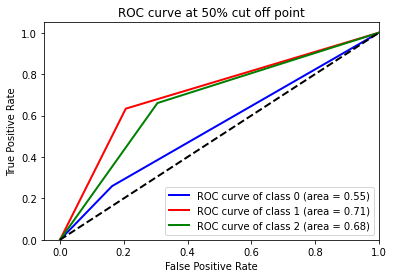

In [ ]:
# 50 percent
STEP_SIZE_TEST=test_generator_50_percent.n//test_generator_50_percent.batch_size
test_generator_50_percent.reset()
preds = model.predict(test_generator_50_percent,verbose=1)
predict_label1 = np.argmax(preds, axis=-1)
labels = [0,1,2]
y_true = test_generator_50_percent.classes
# Binarize ytest with shape (n_samples, n_classes)
y_test_bin = label_binarize(y_true, classes=labels)
# Binarize ypreds with shape (n_samples, n_classes)
y_preds_bin = label_binarize(predict_label1, classes=labels)

# Plot ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3
lw = 2
for i in range(n_classes):
    
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_preds_bin[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve at 50% cut off point')
plt.legend(loc="lower right")
plt.savefig(pathtoResults + 'roc_ES_50.png')


del(preds, y_true, y_test_bin, y_preds_bin, fpr, tpr)

16/16 [==============================] - 102s 7s/step


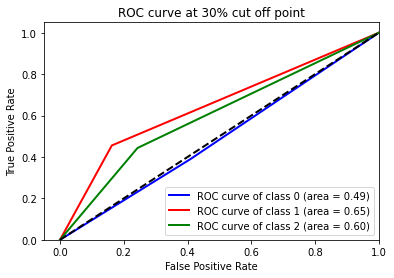

In [ ]:
# 30 percent
STEP_SIZE_TEST=test_generator_30_percent.n//test_generator_30_percent.batch_size
test_generator_30_percent.reset()
preds = model.predict(test_generator_30_percent,verbose=1)
predict_label1 = np.argmax(preds, axis=-1)
labels = [0,1,2]
y_true = test_generator_30_percent.classes
y_test_bin = label_binarize(y_true, classes=labels)
y_preds_bin = label_binarize(predict_label1, classes=labels)

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3
lw = 2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_preds_bin[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve at 30% cut off point')
plt.legend(loc="lower right")
plt.savefig(pathtoResults + 'roc_ES_30.png')


del(preds, y_true, y_test_bin, y_preds_bin, fpr, tpr)

16/16 [==============================] - 101s 7s/step


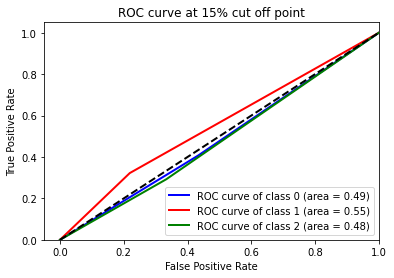

In [ ]:
# 15 percent
STEP_SIZE_TEST=test_generator_15_percent.n//test_generator_15_percent.batch_size
test_generator_15_percent.reset()
preds = model.predict(test_generator_15_percent,verbose=1)
predict_label1 = np.argmax(preds, axis=-1)
labels = [0,1,2]
y_true = test_generator_15_percent.classes
y_test_bin = label_binarize(y_true, classes=labels)
y_preds_bin = label_binarize(predict_label1, classes=labels)

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3
lw = 2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_preds_bin[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve at 15% cut off point')
plt.legend(loc="lower right")
plt.savefig(pathtoResults + 'roc_ES_15.png')

del(preds, y_true, y_test_bin, y_preds_bin, fpr, tpr)

16/16 [==============================] - 101s 7s/step


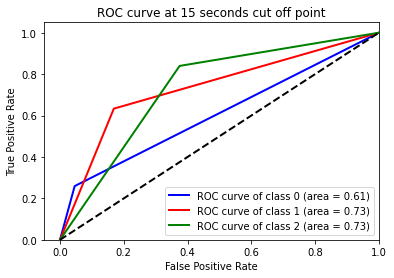

In [ ]:
# 15 seconds
STEP_SIZE_TEST=test_generator_15_secs.n//test_generator_15_secs.batch_size
test_generator_15_secs.reset()
preds = model.predict(test_generator_15_secs,verbose=1)
predict_label1 = np.argmax(preds, axis=-1)
labels = [0,1,2]
y_true = test_generator_15_secs.classes
y_test_bin = label_binarize(y_true, classes=labels)
y_preds_bin = label_binarize(predict_label1, classes=labels)

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3
lw = 2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_preds_bin[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve at 15 seconds cut off point')
plt.legend(loc="lower right")
plt.savefig(pathtoResults + 'roc_ES_15s.png')

del(preds, y_true, y_test_bin, y_preds_bin, fpr, tpr)

16/16 [==============================] - 95s 6s/step


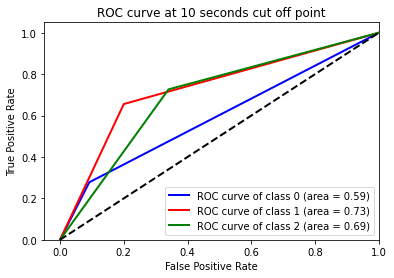

In [ ]:
# 10 seconds
STEP_SIZE_TEST=test_generator_10_secs.n//test_generator_10_secs.batch_size
test_generator_10_secs.reset()
preds = model.predict(test_generator_10_secs,verbose=1)
predict_label1 = np.argmax(preds, axis=-1)
labels = [0,1,2]
y_true = test_generator_10_secs.classes
y_test_bin = label_binarize(y_true, classes=labels)
y_preds_bin = label_binarize(predict_label1, classes=labels)

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3
lw = 2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_preds_bin[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve at 10 seconds cut off point')
plt.legend(loc="lower right")
plt.savefig(pathtoResults + 'roc_ES_10s.png')

del(preds, y_true, y_test_bin, y_preds_bin, fpr, tpr)

16/16 [==============================] - 99s 7s/step


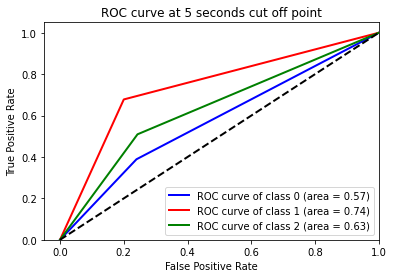

In [ ]:
# 5 seconds
STEP_SIZE_TEST=test_generator_5_secs.n//test_generator_5_secs.batch_size
test_generator_5_secs.reset()
preds = model.predict(test_generator_5_secs,verbose=1)
predict_label1 = np.argmax(preds, axis=-1)
labels = [0,1,2]
y_true = test_generator_5_secs.classes
y_test_bin = label_binarize(y_true, classes=labels)
y_preds_bin = label_binarize(predict_label1, classes=labels)

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3
lw = 2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_preds_bin[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve at 5 seconds cut off point')
plt.legend(loc="lower right")
plt.savefig(pathtoResults + 'roc_ES_5s.png')

del(preds, y_true, y_test_bin, y_preds_bin, fpr, tpr)

16/16 [==============================] - 98s 6s/step


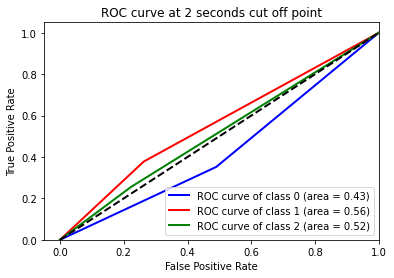

In [ ]:
# 2 seconds
STEP_SIZE_TEST=test_generator_2_secs.n//test_generator_2_secs.batch_size
test_generator_2_secs.reset()
preds = model.predict(test_generator_2_secs,verbose=1)
predict_label1 = np.argmax(preds, axis=-1)
labels = [0,1,2]
y_true = test_generator_2_secs.classes
y_test_bin = label_binarize(y_true, classes=labels)
y_preds_bin = label_binarize(predict_label1, classes=labels)

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3
lw = 2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_preds_bin[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve at 2 seconds cut off point')
plt.legend(loc="lower right")
plt.savefig(pathtoResults + 'roc_ES_2s.png')

del(preds, y_true, y_test_bin, y_preds_bin, fpr, tpr)